In [32]:
import numpy as np
import matplotlib.pyplot as plt

# --- Sample a_i ---
def sample_a(L, distribution='gauss', symmetric=True, shift=0.0, sigma=1.0, alpha=1.6, xm=1.0, scale='sk'):
    """
    Sample couplings a_ij for the lattice.

    Parameters:
        L : int
            Lattice size (LxL)
        distribution : 'gauss' or 'pareto'
        symmetric : bool
            True → allow negative values, False → positive only
        shift : float
            Additive shift to the whole distribution
        sigma : float
            Standard deviation for Gaussian
        alpha : float
            Exponent for Pareto
        xm : float
            Scale for Pareto
        scale : str
            Scaling for Gaussian ('sk') or Pareto ('levy')
    """
    N = L * L

    if distribution == 'gauss':
        if scale == 'sk':
            a = np.random.normal(0, sigma/np.sqrt(N), size=N)
        else:
            a = np.random.normal(0, sigma, size=N)
        if not symmetric:
            a = np.abs(a)
    elif distribution == 'pareto':
        u = np.random.rand(N)
        mag = xm * (u ** (-1/alpha) - 1)
        if symmetric:
            signs = np.random.choice([-1, 1], size=N)
            a = signs * mag
        else:
            a = mag
        if scale == 'levy':
            a = a * N ** (-1/alpha)
    else:
        raise ValueError("distribution must be 'gauss' or 'pareto'")

    a += shift
    return a.reshape(L, L)
# --- Initialize spins (3-state: -1, 0, +1) ---
def initialize_spins(L):
    return np.random.choice([-1, 0, 1], size=(L, L))


# --- Local field ---
def local_field(spins, a, i, j):
    L = spins.shape[0]
    neighbors = [((i, (j + 1) % L)),
                 ((i, (j - 1) % L)),
                 (((i + 1) % L, j)),
                 (((i - 1) % L, j))]
    h = 0.0
    for ni, nj in neighbors:
        h += a[i, j] * a[ni, nj] * spins[ni, nj]
    return h


# --- One Glauber sweep (3-state) ---
def glauber_sweep(spins, a, beta):
    L = spins.shape[0]
    for _ in range(L * L):
        i, j = np.random.randint(L), np.random.randint(L)
        s_old = spins[i, j]
        h = local_field(spins, a, i, j)

        # Propose new spin different from the current one
        possible_states = [-1, 0, 1]
        possible_states.remove(s_old)
        s_new = np.random.choice(possible_states)

        # ΔE = -h * (s_new - s_old)
        dE = -h * (s_new - s_old)

        # Glauber acceptance probability
        p_flip = 1.0 / (1.0 + np.exp(beta * dE))
        if np.random.rand() < p_flip:
            spins[i, j] = s_new

    return spins


# --- Weighted magnetization M_z ---
def compute_weighted_Mz(spins, a):
    return np.sum(a * spins)


# --- Kurtosis ---
def compute_kurtosis(x):
    x = np.array(x)
    mean = np.mean(x)
    std = np.std(x)
    if std == 0:
        return 0.0
    return np.mean((x - mean) ** 4) / (std ** 4)


# --- Run model ---
def run_three_state_model(L=32, beta=0.5, sweeps=2000, a=None, delta_t=1):
    """
    Runs the three-state spin model and computes:
      - X_series: cumulative sum of ΔM if delta_t>0, or of M if delta_t==0
      - delta_X: time differences of X_series over interval delta_t
      - kurt_x: kurtosis of X_series
      - kurt_delta: kurtosis of delta_X
    """
    if a is None:
        a = sample_a_gauss(L)

    spins = initialize_spins(L)
    M_prev = compute_weighted_Mz(spins, a)

    M_series = [M_prev]
    delta_M = []

    # --- Run Glauber dynamics ---
    for t in range(1, sweeps):
        spins = glauber_sweep(spins, a, beta)
        M_new = compute_weighted_Mz(spins, a)
        M_series.append(M_new)
        delta_M.append(M_new - M_prev)
        M_prev = M_new

    M_series = np.array(M_series)
    delta_M = np.array(delta_M)

    # --- Construct X(t) ---
    if delta_t < 0:
        raise ValueError("delta_t must be >= 0")

    if delta_t == 0:
        X_series = np.cumsum(M_series)
    else:
        X_series = np.cumsum(delta_M)

    # --- Compute ΔX ---
    if delta_t == 0:
        delta_X = np.diff(X_series, prepend=X_series[0])
    else:
        delta_X = X_series[delta_t:] - X_series[:-delta_t]

    # --- Compute kurtoses ---
    kurt_x = compute_kurtosis(X_series)
    kurt_delta = compute_kurtosis(delta_X)

    return X_series, delta_X, kurt_x, kurt_delta


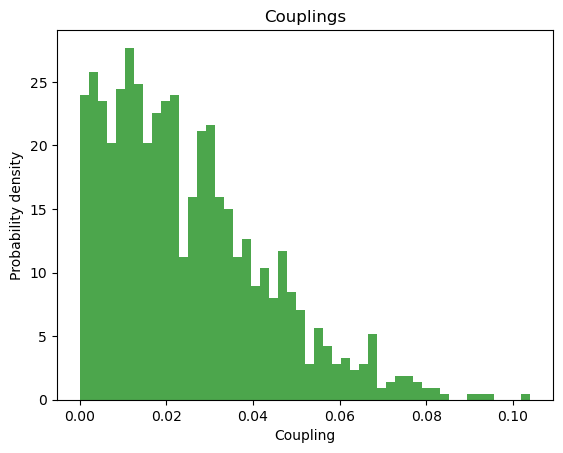

In [50]:
L = 32

a =sample_a(L,
            distribution='gauss',
            symmetric=False,
            shift=0.0,
            sigma=1.0,
            alpha=1.6,
            xm=1.0,
            scale='sk'
           )
plt.figure()
plt.hist(a.reshape(L*L) , bins=50, density=True, alpha=0.7, color='green')
plt.xlabel('Coupling')
plt.ylabel('Probability density')
plt.title('Couplings')
plt.show()

Kurtosis of M_z(t): 1.9236314401692354
Kurtosis of ΔM_z(t): 2.7977381446952228


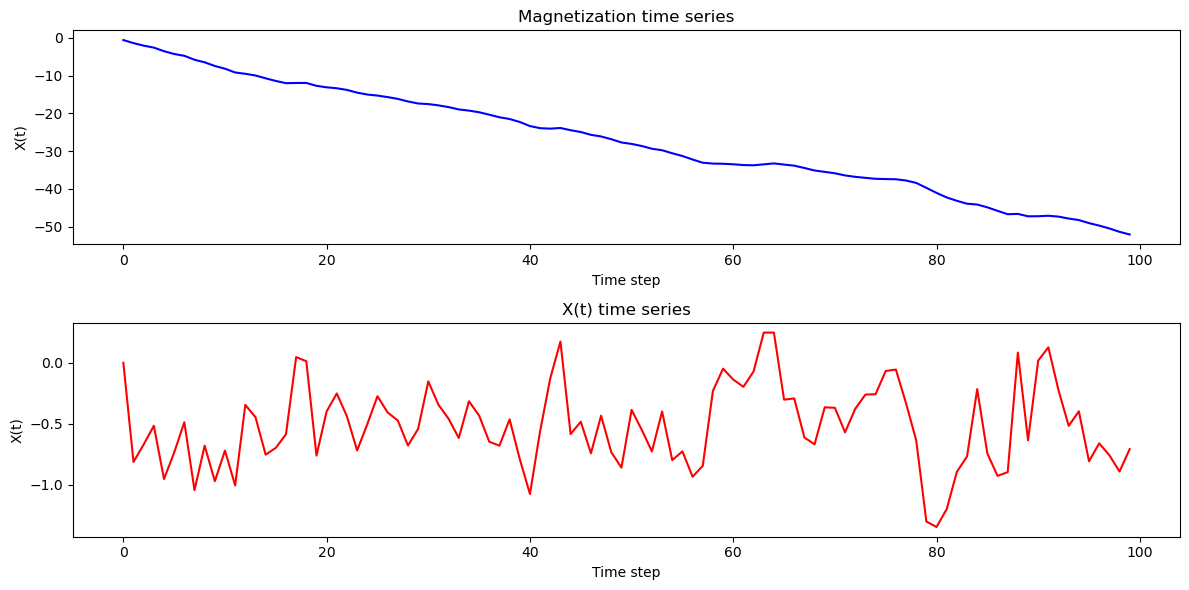

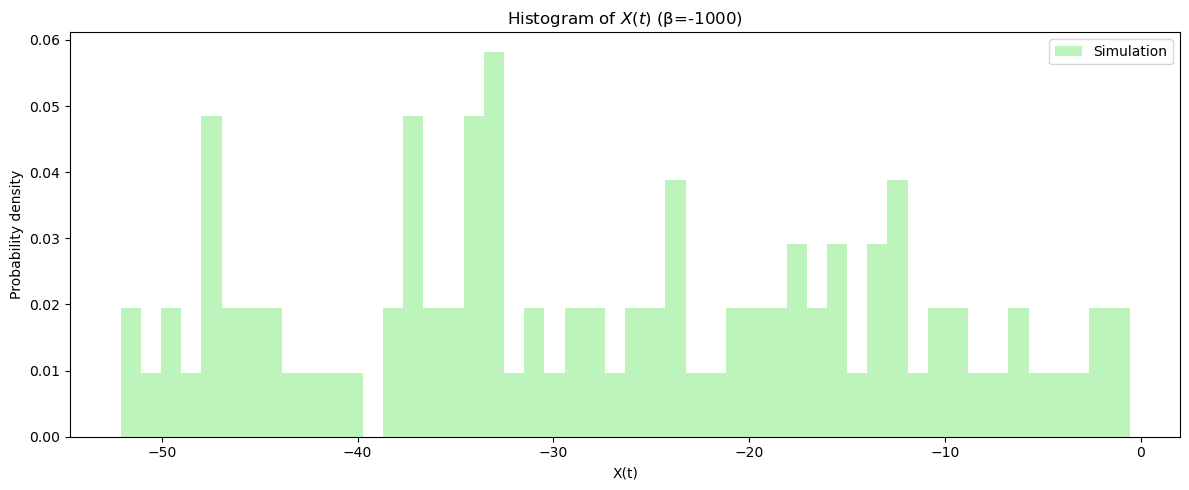

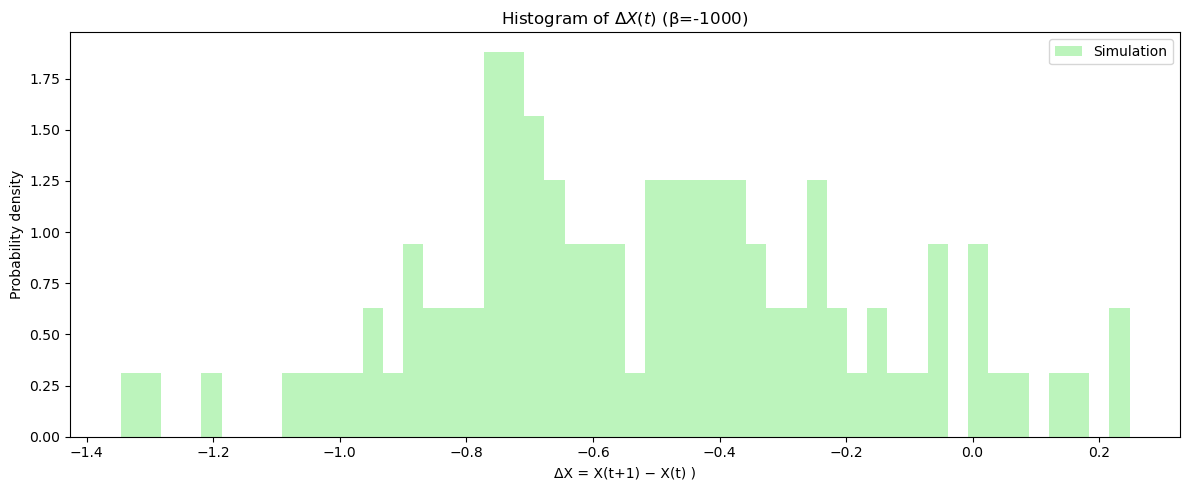

In [57]:
beta = -1000
sweeps = 100
deltat = 0

M, delta_M, kurt_M, kurt_delta = run_three_state_model(
    L=L,
    beta=beta,
    sweeps=sweeps,
    a=a,
    delta_t = deltat
)

print("Kurtosis of M_z(t):", kurt_M)
print("Kurtosis of ΔM_z(t):", kurt_delta)

# --- Plot ---
plt.figure(figsize=(12,6))
plt.subplot(2,1,1)
plt.plot(M, color='blue')
plt.xlabel('Time step')
plt.ylabel('X(t)')
plt.title('Magnetization time series')

plt.subplot(2,1,2)
plt.plot(delta_M, color='red')
plt.xlabel('Time step')
plt.ylabel('X(t)')
plt.title('X(t) time series')
plt.tight_layout()
plt.show()

# --- P(X) histogram vs analytic ---
plt.figure(figsize=(12,5))
counts, bins, _ = plt.hist(M, bins=50, density=True, alpha=0.6, color='lightgreen', label='Simulation')
plt.xlabel("X(t)")
plt.ylabel("Probability density")
plt.title(f"Histogram of $X(t)$ (β={beta})")
plt.legend()
plt.tight_layout()
plt.show()

# --- P(X) histogram vs analytic ---
plt.figure(figsize=(12,5))
counts, bins, _ = plt.hist(delta_M, bins=50, density=True, alpha=0.6, color='lightgreen', label='Simulation')
plt.xlabel("ΔX = X(t+1) − X(t) )")
plt.ylabel("Probability density")
plt.title(f"Histogram of Δ$X(t)$ (β={beta})")
plt.legend()
plt.tight_layout()
plt.show()

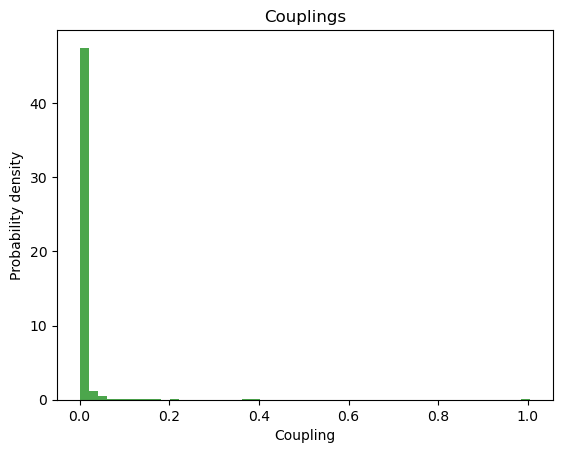

In [38]:
L = 32

a =sample_a(L,
            distribution='pareto',
            symmetric=False,
            shift=0.0,
            sigma=1.0,
            alpha=1.0,
            xm=1.0,
            scale='levy'
           )
plt.figure()
plt.hist(a.reshape(L*L) , bins=50, density=True, alpha=0.7, color='green')
plt.xlabel('Coupling')
plt.ylabel('Probability density')
plt.title('Couplings')
plt.show()


Kurtosis of M_z(t): 1.838616830513419
Kurtosis of ΔM_z(t): 2.4970822645528843


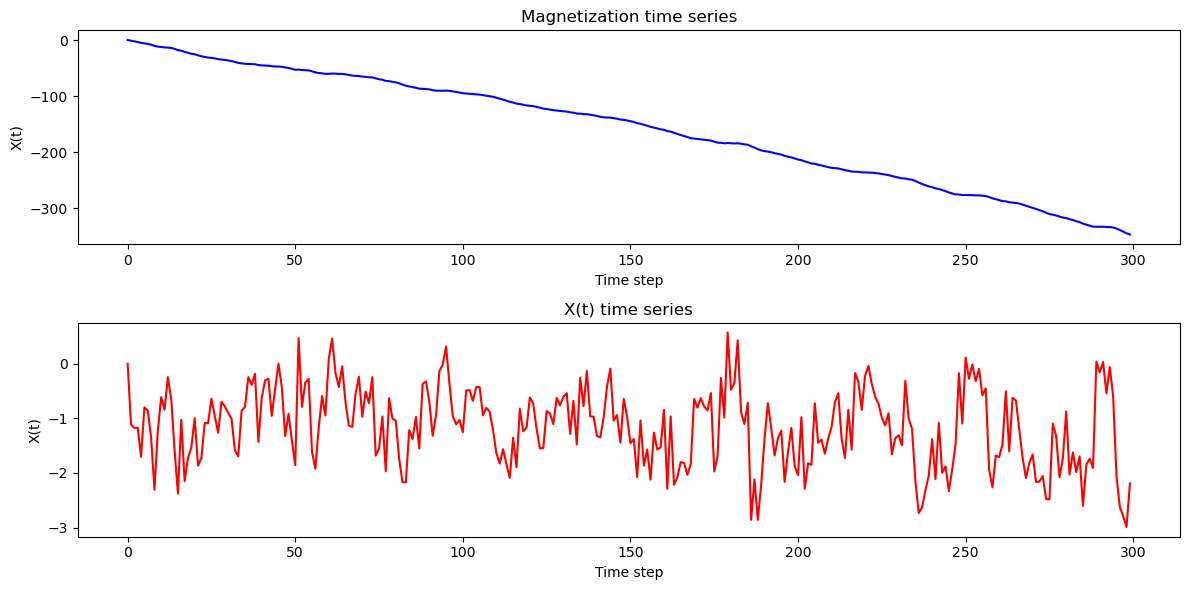

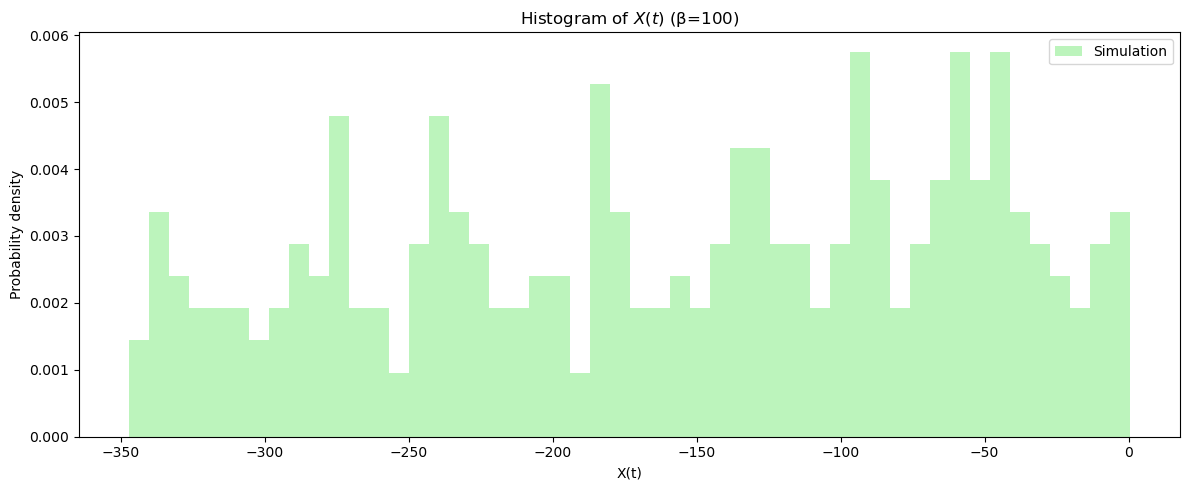

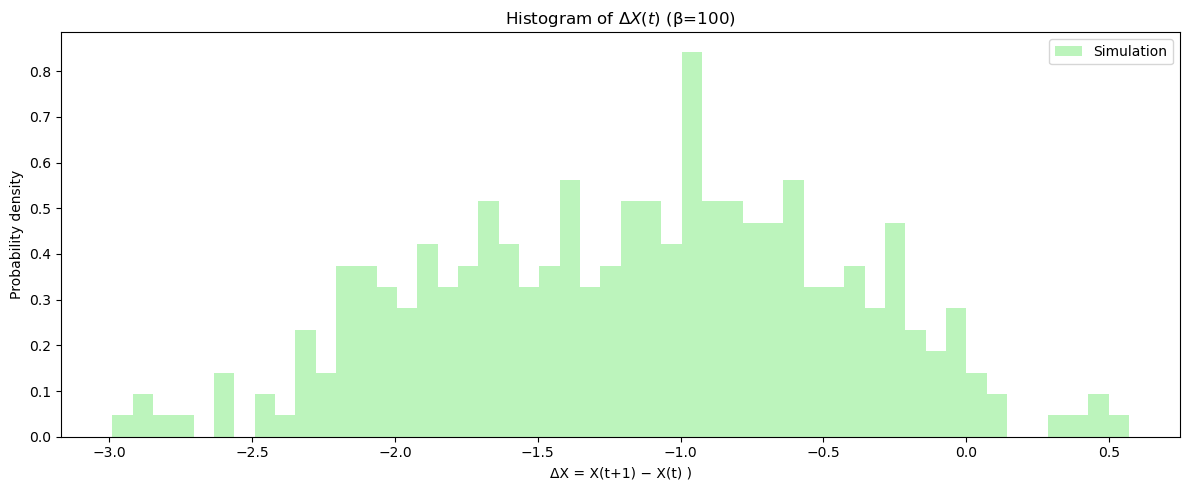

In [49]:
beta = 100
sweeps = 300
deltat = 0

M, delta_M, kurt_M, kurt_delta = run_three_state_model(
    L=L,
    beta=beta,
    sweeps=sweeps,
    a=a,
    delta_t = deltat
)

print("Kurtosis of M_z(t):", kurt_M)
print("Kurtosis of ΔM_z(t):", kurt_delta)

# --- Plot ---
plt.figure(figsize=(12,6))
plt.subplot(2,1,1)
plt.plot(M, color='blue')
plt.xlabel('Time step')
plt.ylabel('X(t)')
plt.title('Magnetization time series')

plt.subplot(2,1,2)
plt.plot(delta_M, color='red')
plt.xlabel('Time step')
plt.ylabel('X(t)')
plt.title('X(t) time series')
plt.tight_layout()
plt.show()

# --- P(X) histogram vs analytic ---
plt.figure(figsize=(12,5))
counts, bins, _ = plt.hist(M, bins=50, density=True, alpha=0.6, color='lightgreen', label='Simulation')
plt.xlabel("X(t)")
plt.ylabel("Probability density")
plt.title(f"Histogram of $X(t)$ (β={beta})")
plt.legend()
plt.tight_layout()
plt.show()

# --- P(X) histogram vs analytic ---
plt.figure(figsize=(12,5))
counts, bins, _ = plt.hist(delta_M, bins=50, density=True, alpha=0.6, color='lightgreen', label='Simulation')
plt.xlabel("ΔX = X(t+1) − X(t) )")
plt.ylabel("Probability density")
plt.title(f"Histogram of Δ$X(t)$ (β={beta})")
plt.legend()
plt.tight_layout()
plt.show()